In [ ]:
import torch, os
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA available: True
GPU: Tesla T4


In [ ]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# resnet50_tfidf_baseline.py
# Fast multimodal baseline: ResNet-50 (frozen) + TF-IDF(findings+impression) → 5-label head
import os, json, math, random
import numpy as np, pandas as pd
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as T

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# --------

In [ ]:
EDEMA_MIN_PREC_FOR_TH   = 0.85

# ---- SPEED/SEED ----
andom.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
try: mp.set_start_method("spawn", force=True)
except RuntimeError: pass
try: mp.set_sharing_strategy("file_system")
except Exception: pass
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try: torch.set_float32_matmul_precision("high")
except: pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 0          # was 2
PIN_MEMORY  = False      # safer with 0 workers
PERSIST     = False


=== CheXpert-5 Prevalence (uncertain −2 excluded) ===
           label  n_pos  n_neg  n_labeled prev_%
Pleural_Effusion    598   3248       3846  15.5%
   Consolidation    502   3343       3845  13.1%
     Atelectasis    348   3485       3833   9.1%
    Cardiomegaly    250   3600       3850   6.5%
           Edema     96   3754       3850   2.5%


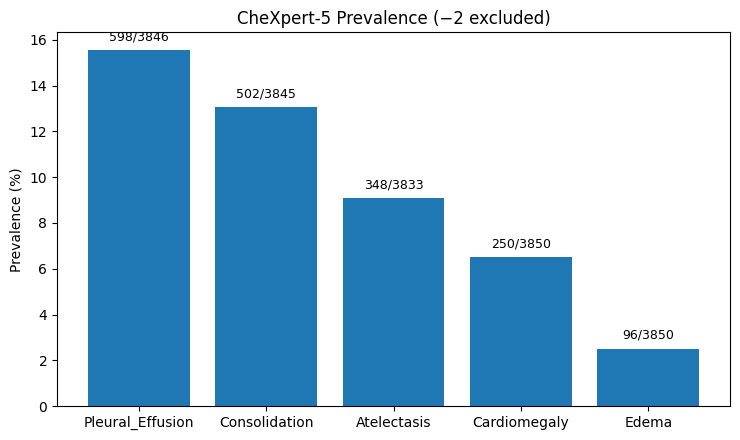

In [ ]:
# Prevalence check + bar plot for CheXpert-5
# - Excludes uncertain/ignored (-2) from the denominator
# - Labels expected in columns with values {1=pos, 0=neg, -2=uncertain-ignored}

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- EDIT THIS ---
CSV_PATH = "/content/drive/MyDrive/iu5_clean.csv"  # your CSV
LABELS = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Pleural_Effusion"]
# -----------------

df = pd.read_csv(CSV_PATH)

rows = []
for lab in LABELS:
    col = df[lab]
    mask = col != -2                  # exclude uncertain-ignored
    n_labeled = int(mask.sum())
    n_pos = int((col == 1).sum())
    n_neg = int((col == 0).sum())
    prev = (n_pos / n_labeled) if n_labeled > 0 else np.nan
    rows.append({"label": lab, "n_pos": n_pos, "n_neg": n_neg, "n_labeled": n_labeled, "prevalence": prev})

stats = pd.DataFrame(rows).sort_values("prevalence", ascending=False)

# Pretty % string for table (pasteable to slides)
stats["prev_%"] = (stats["prevalence"] * 100).round(1).astype(str) + "%"

print("\n=== CheXpert-5 Prevalence (uncertain −2 excluded) ===")
print(stats[["label","n_pos","n_neg","n_labeled","prev_%"]].to_string(index=False))

# --- Bar plot (single clean figure) ---
plt.figure(figsize=(7.5,4.5))
x = np.arange(len(stats))
vals = stats["prevalence"].values * 100
plt.bar(x, vals)  # (No custom colors → Slides theme will handle it)
plt.xticks(x, stats["label"], rotation=0)
plt.ylabel("Prevalence (%)")
plt.title("CheXpert-5 Prevalence (−2 excluded)")

# Annotate bars with n_pos / n_labeled
for i, (v, npos, ntot) in enumerate(zip(vals, stats["n_pos"], stats["n_labeled"])):
    plt.text(i, v + max(vals)*0.02 if len(vals)>0 else 1,
             f"{npos}/{ntot}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("chex5_prevalence.png", dpi=220)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using: /content/drive/MyDrive/NLMCXR_images/CXR28_IM-1231-1001.png
Saved to: /content/edema_original_vs_aug.png


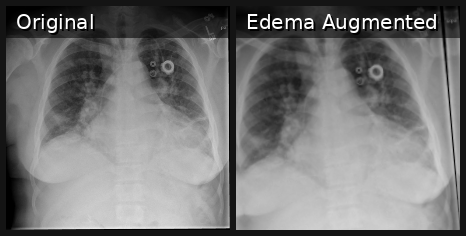

In [ ]:
# ============== One Original + One Augmented (OpenCV) ==============
import os, random
import cv2, numpy as np, pandas as pd

# ---- EDIT ----
CSV_PATH = "/content/drive/MyDrive/iuxray_labels.csv"
IMG_ROOT = "/content/drive/MyDrive/NLMCXR_images"
IMG_SIZE = 224
SEED = 42
# --------------

random.seed(SEED); np.random.seed(SEED)

# (Optional) mount Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
except Exception:
    pass

# ---------- helpers ----------
def ensure_rgb(img):
    if img is None: return None
    if len(img.shape)==2: return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def center_crop(img, size):
    h,w = img.shape[:2]
    y = max(0,(h-size)//2); x = max(0,(w-size)//2)
    return img[y:y+size, x:x+size]

def random_crop_reflect(img, out_size, pad):
    im = cv2.copyMakeBorder(img, pad,pad,pad,pad, cv2.BORDER_REFLECT_101)
    H,W = im.shape[:2]
    y = np.random.randint(0, H-out_size+1); x = np.random.randint(0, W-out_size+1)
    return im[y:y+out_size, x:x+out_size]

def small_rotate(img, deg=5):
    h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), np.random.uniform(-deg,deg), 1.0)
    return cv2.warpAffine(img, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def bc_jitter(img):
    alpha = float(np.random.uniform(0.92, 1.08))  # contrast
    beta  = float(np.random.uniform(-20, 20))     # brightness
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

def edema_aug(x):
    im = cv2.resize(x, (256,256), interpolation=cv2.INTER_LINEAR)
    if np.random.rand() < 0.5: im = cv2.flip(im, 1)
    im = random_crop_reflect(im, IMG_SIZE, pad=16)
    im = small_rotate(im, deg=5)
    im = bc_jitter(im)
    return im

def title(img, text):
    im = img.copy()
    cv2.putText(im, text, (10,26), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 3, cv2.LINE_AA)
    cv2.putText(im, text, (10,26), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)
    return im

# ---------- pick one Edema-positive ----------
df = pd.read_csv(CSV_PATH)
pos = df[df["Edema"]==1]
assert not pos.empty, "No Edema-positive rows found (Edema==1)."

row = pos.sample(1, random_state=SEED).iloc[0]
candidates = ["frontal","image","img_path","path"]
img_path = None
for c in candidates:
    if c in pos.columns and pd.notnull(row.get(c, None)):
        p = str(row[c])
        if os.path.exists(p): img_path = p; break
        base = os.path.basename(p)
        p2 = os.path.join(IMG_ROOT, base if base.lower().endswith(".png") else base + ".png")
        if os.path.exists(p2): img_path = p2; break
if img_path is None and pd.notnull(row.get("report_id", None)):
    rid = str(row["report_id"]); p3 = os.path.join(IMG_ROOT, rid + ".png")
    if os.path.exists(p3): img_path = p3
assert img_path is not None, "Could not resolve image path."

print("Using:", img_path)

# ---------- make side-by-side ----------
orig = ensure_rgb(cv2.imread(img_path, cv2.IMREAD_UNCHANGED))
orig = cv2.resize(orig, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
aug  = edema_aug(orig)

# --- Formal title drawing (PIL TrueType, fallback to OpenCV) ---
def title(img, text):
    """
    Draws a formal-looking title using a TrueType font (DejaVu Sans).
    Falls back to OpenCV Hershey Triplex if PIL/TTF not available.
    Adds a subtle top bar for contrast.
    """
    im = img.copy()
    h, w = im.shape[:2]

    try:
        from PIL import Image, ImageDraw, ImageFont
        import matplotlib
        # Locate bundled DejaVu Sans (ships with matplotlib)
        try:
            from matplotlib import font_manager
            font_path = font_manager.findfont("DejaVu Sans")
        except Exception:
            font_path = os.path.join(matplotlib.get_data_path(), "fonts/ttf/DejaVuSans.ttf")

        # Create PIL canvas
        pil_img = Image.fromarray(im)
        draw = ImageDraw.Draw(pil_img)

        # Semi-transparent top bar for readability
        bar_h = 32
        overlay = Image.new("RGBA", (w, bar_h), (0, 0, 0, 140))
        pil_img.paste(overlay, (0, 0), overlay)

        # Load font (adjust size as needed)
        font = ImageFont.truetype(font_path, size=20)

        # Shadow + text
        draw.text((12, 6), text, font=font, fill=(0, 0, 0, 255))     # slight shadow
        draw.text((10, 4), text, font=font, fill=(255, 255, 255, 255))

        return np.array(pil_img)

    except Exception:
        # Fallback: OpenCV with Hershey Triplex (most formal of Hershey family)
        # Add solid top bar
        cv2.rectangle(im, (0, 0), (w, 32), (0, 0, 0), -1)
        font = cv2.FONT_HERSHEY_TRIPLEX
        scale, thick = 0.7, 1
        # Shadow
        cv2.putText(im, text, (12, 24), font, scale, (0, 0, 0), 2, cv2.LINE_AA)
        # White
        cv2.putText(im, text, (10, 22), font, scale, (255, 255, 255), thick, cv2.LINE_AA)
        return im

left  = title(orig, "Original")
right = title(aug,  "Edema Augmented")
pad = 6
canvas = np.full((IMG_SIZE+2*pad, 2*IMG_SIZE+3*pad, 3), 20, dtype=np.uint8)
canvas[pad:pad+IMG_SIZE, pad:pad+IMG_SIZE] = left
canvas[pad:pad+IMG_SIZE, 2*pad+IMG_SIZE:2*pad+2*IMG_SIZE] = right

OUT = "/content/edema_original_vs_aug.png"
cv2.imwrite(OUT, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
print("Saved to:", OUT)

# show in Colab
try:
    from google.colab.patches import cv2_imshow
    cv2_imshow(cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
except Exception:
    import matplotlib.pyplot as plt
    plt.imshow(canvas); plt.axis("off"); plt.show()


In [ ]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch; print(torch.version.cuda, torch.cuda.is_available())


In [ ]:

import os, json, time, gc, random, hashlib, math, re
from typing import Any, Optional, List

import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from contextlib import nullcontext

import torchvision.transforms as T
import timm
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.model_selection import GroupShuffleSplit

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

In [ ]:

# ============================================
# Multimodal (ViT + SBERT) with Edema-aware training
# - RepeatAug for Edema+, MixUp on Edema+
# - Aux losses (pos-margin, hard-negative), contrastive align (optional)
# - Leak-safe split, val calibration, PR/ROC plots
# - SANITY_MODE to quickly validate data/model before training
# ============================================


# -------- CONFIG --------
DATA_CSV_PATH = "/content/drive/MyDrive/iu5_clean.csv"
IMG_ROOT_DIR  = "/content/drive/MyDrive/NLMCXR_images"  # use local copy for speed
EMBEDDINGS_CACHED_PATH = "/content/drive/MyDrive/cached_text_embeddings.parquet"

REPORT_DIR              = "/content/drive/MyDrive/mm_report"

CHEX5 = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural_Effusion']
NUM_CLASSES = len(CHEX5); EDEMA_IDX = CHEX5.index('Edema')

VIT_NAME      = "deit_small_patch16_224"   # vit embed_dim ≈ 384
IMG_SIZE      = 224
TDIM          = 384 * 2                    # findings + impression
ALIGN_DIM     = 256
USE_CONTRAST  = True
ALIGN_LAMBDA  = 0.05

BATCH_SIZE    = 32
TOTAL_EPOCHS  = 35
LR_BASE       = 3e-4
WEIGHT_DECAY  = 1e-4
SEED          = 42
PRINT_EVERY   = 50

# SANITY toggles
SANITY_MODE       = True  # ← run quick checks and exit; set False to train
SANITY_N_SAMPLES  = 16
SANITY_STEPS      = 6
USE_BF16_AMP      = True   # bfloat16 autocast (no GradScaler)

# Text dropout schedule (cool earlier → keep text more often)
TEXTDROP_SCHEDULE = {0:1.0, 1:0.5, 2:0.3}  # then 0.2 afterward

# Asym focal tuning (emphasize Edema negatives)
GAMMA_NEG_VEC_LIST = [3.3, 3.0, 3.2, 4.2, 3.0]
GAMMA_POS_VEC_LIST = [1.0, 1.0, 1.0, 1.3, 1.0]

# Edema-only augmentation knobs
MINORITY_VIEWS = 3
MIXUP_P_ED     = 0.15
MIXUP_ALPHA    = 0.20

# Edema auxiliary losses
POS_MARGIN   = 1.2
LAM_POS_M    = 0.05
NEG_PROB_TH  = 0.55
LAM_HN       = 0.05

# Gentle logit prior toward Edema
LOGIT_BIAS   = [0.0, 0.0, 0.0, 0.25, 0.0]

# Training sampler: force ≥K Edema+ per batch
MIN_EDEMA_POS_PER_BATCH = 2

# Edema threshold target for plots
EDEMA_MIN_PREC_FOR_TH   = 0.85

# ---- SPEED/SEED ----
andom.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
try: mp.set_start_method("spawn", force=True)
except RuntimeError: pass
try: mp.set_sharing_strategy("file_system")
except Exception: pass
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try: torch.set_float32_matmul_precision("high")
except: pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
r
# --------- IO utils ---------
def ensure_dir(p): os.makedirs(p, exist_ok=True)

def _to_np(x: Any) -> np.ndarray:
    if isinstance(x, np.ndarray): return x.astype(np.float32)
    if isinstance(x, (list, tuple)): return np.asarray(x, dtype=np.float32)
    if isinstance(x, str):
        try: return np.asarray(json.loads(x), dtype=np.float32)
        except Exception: return np.zeros(384, dtype=np.float32)
    return np.asarray(x, dtype=np.float32)

# --------- Grouping (IU X-ray friendly) ---------
def infer_group_id_from_row(row) -> str:
    rid = str(row.get('report_id', '')).strip()
    if re.match(r'^[A-Za-z]*\d+$', rid):  # e.g., CXR8
        return rid
    fname = None
    if 'frontal' in row and isinstance(row['frontal'], str): fname = row['frontal']
    elif 'image_filename' in row and isinstance(row['image_filename'], str): fname = row['image_filename']
    if fname:
        base = os.path.basename(fname)
        m = re.match(r'^([^_]+)_', base)
        if m: return m.group(1)
    key = (str(row.get('articleDate','')) + '|' + str(row.get('title',''))).encode('utf-8')
    return hashlib.sha1(key).hexdigest()[:12] if key.strip() != b'|' else f"row{int(row.name)}"

def ensure_group_id(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'patient_id' in df.columns:
        df['group_id'] = df['patient_id'].astype(str); return df
    df['group_id'] = df.apply(infer_group_id_from_row, axis=1)
    if df['group_id'].str.match(r'^[A-Za-z]*\d+$').mean() < 0.5:
        print("[WARN] <50% group_id look like study ids; check naming.")
    return df

# --------- Leak-safe split ---------
def group_train_val_test_split(df, group_col='group_id', train=0.7, val=0.15, seed=SEED):
    if group_col not in df.columns:
        raise ValueError(f"Need {group_col} for leakage-safe split.")
    groups = df[group_col].astype(str).values
    uniq = np.unique(groups)
    gss1 = GroupShuffleSplit(n_splits=1, train_size=train, random_state=seed)
    tr_idx, hold_idx = next(gss1.split(uniq, groups=uniq))
    tr_groups, hold_groups = uniq[tr_idx], uniq[hold_idx]
    hold_df = df[np.isin(groups, hold_groups)]
    uniq_hold = np.unique(hold_df[group_col].astype(str).values)
    rel_val = val / (1 - train)
    gss2 = GroupShuffleSplit(n_splits=1, train_size=rel_val, random_state=seed+1)
    va_idx, te_idx = next(gss2.split(uniq_hold, groups=uniq_hold))
    va_groups, te_groups = uniq_hold[va_idx], uniq_hold[te_idx]
    df_tr = df[np.isin(groups, tr_groups)].copy()
    df_va = df[np.isin(groups, va_groups)].copy()
    df_te = df[np.isin(groups, te_groups)].copy()
    a=set(df_tr[group_col].astype(str)); b=set(df_va[group_col].astype(str)); c=set(df_te[group_col].astype(str))
    assert a.isdisjoint(b) and a.isdisjoint(c) and b.isdisjoint(c), "Group overlap across splits!"
    print(f"[SPLIT] train={len(df_tr)} val={len(df_va)} test={len(df_te)} | groups T/V/E = {len(a)}/{len(b)}/{len(c)}")
    return df_tr, df_va, df_te

# --------- Cache attach (split-only) ---------
def attach_cache_split_only(df_split, cache_path):
    if not os.path.exists(cache_path): raise FileNotFoundError(cache_path)
    c = pd.read_parquet(cache_path)
    need = {'report_id','findings_embed','impression_embed'}
    if not need.issubset(c.columns):
        miss = need - set(c.columns); raise ValueError(f"Cache missing: {miss}")
    out = df_split.merge(c[list(need)], on='report_id', how='left', validate='one_to_one')
    if out['findings_embed'].isna().any() or out['impression_embed'].isna().any():
        bad = out[out['findings_embed'].isna() | out['impression_embed'].isna()]['report_id'].tolist()[:10]
        raise RuntimeError(f"Cache mismatch on split (e.g., {bad[:5]} ...)")
    out['findings_embed']   = out['findings_embed'].apply(_to_np)
    out['impression_embed'] = out['impression_embed'].apply(_to_np)
    return out

# --------- Transforms (no lambdas → picklable) ---------
IMAGENET_MEAN, IMAGENET_STD = [0.485,0.456,0.406], [0.229,0.224,0.225]

tf_mild = T.Compose([
    T.Resize(256, interpolation=T.InterpolationMode.BILINEAR),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

tf_edema = T.Compose([
    T.Resize(256, interpolation=T.InterpolationMode.BILINEAR),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomCrop(IMG_SIZE, padding=16, padding_mode='reflect'),
    T.RandomRotation(5),
    T.ColorJitter(brightness=0.08, contrast=0.08),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# --------- Dataset ---------
class CXRMultiModal(Dataset):
    """RepeatAug: duplicate Edema+ rows (minority_views) with stronger tf."""
    def __init__(self, df: pd.DataFrame, img_root: str,
                 tf_default: T.Compose, tf_edema: T.Compose,
                 edema_col='Edema', minority_views=3):
        self.df = df.reset_index(drop=True)
        self.root = img_root
        self.tf_default = tf_default
        self.tf_edema = tf_edema
        self.edema_col = edema_col
        self.minority_views = minority_views
        if ('frontal' not in self.df.columns) and ('image_filename' not in self.df.columns):
            raise ValueError("CSV must contain 'frontal' or 'image_filename' for image paths.")
        idx_major = self.df.index[self.df[self.edema_col] != 1].tolist()
        idx_minor = self.df.index[self.df[self.edema_col] == 1].tolist()
        self._expanded = idx_major + idx_minor * self.minority_views

    def __len__(self): return len(self._expanded)

    def __getitem__(self, k: int):
        i = self._expanded[k]
        row = self.df.iloc[i]
        rel = str(row['frontal'] if 'frontal' in row else row['image_filename'])
        fp  = rel if os.path.isabs(rel) else os.path.join(self.root, rel)
        try:
            im = Image.open(fp).convert("RGB")   # convert here (no T.Lambda)
        except Exception:
            im = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8), mode='RGB')
        is_edema = (float(row[self.edema_col]) == 1.0)
        tf = self.tf_edema if is_edema else self.tf_default
        x = tf(im)
        femb = torch.tensor(_to_np(row['findings_embed']),   dtype=torch.float32)
        iemb = torch.tensor(_to_np(row['impression_embed']), dtype=torch.float32)
        t    = torch.cat([femb, iemb], dim=0)   # [TDIM]
        y = torch.tensor(row[CHEX5].values.astype(float), dtype=torch.float32)
        rid = row.get('report_id', f'idx_{i}')
        return x, t, y, rid

# --------- Edema-aware finite batch sampler ---------
class EdemaAwareBatchSampler:
    def __init__(self, ds, batch_size=32, min_edema_pos=4, drop_last=False):
        self.ds = ds
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.pos_idx = [j for j in range(len(ds._expanded))
                        if float(ds.df.iloc[ds._expanded[j]]['Edema']) == 1.0]
        self.neg_idx = [j for j in range(len(ds._expanded))
                        if float(ds.df.iloc[ds._expanded[j]]['Edema']) != 1.0]
        if len(self.pos_idx) == 0:
            raise RuntimeError("No Edema positives found in train split")
        self.min_pos = min_edema_pos
        n = len(ds._expanded)
        self.num_batches = (n // batch_size) if drop_last else math.ceil(n / batch_size)

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        rng = np.random.default_rng()
        pos = rng.permutation(self.pos_idx)
        neg = rng.permutation(self.neg_idx)
        pp, nn = 0, 0
        for _ in range(self.num_batches):
            if pp + self.min_pos > len(pos):
                pos = np.concatenate([pos, rng.permutation(self.pos_idx)]); pp = 0
            need_neg = max(self.batch_size - self.min_pos, 0)
            if nn + need_neg > len(neg):
                neg = np.concatenate([neg, rng.permutation(self.neg_idx)]); nn = 0
            batch = np.concatenate([pos[pp:pp+self.min_pos], neg[nn:nn+need_neg]])
            pp += self.min_pos; nn += need_neg
            if batch.size > self.batch_size: batch = batch[:self.batch_size]
            perm = rng.permutation(batch.size)
            yield batch[perm].tolist()

# --------- Model ---------
class FusedViTSBERT(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, vname=VIT_NAME, tdim=TDIM,
                 p_textdrop=0.4, align_dim=ALIGN_DIM, use_specialist=True):
        super().__init__()
        self.vit = timm.create_model(vname, pretrained=True)
        vdim = self.vit.head.in_features
        self.vit.head = nn.Identity()

        self.text_proj = nn.Sequential(
            nn.Linear(tdim, tdim), nn.ReLU(), nn.Dropout(0.10)
        )
        self.v_align = nn.Linear(vdim, align_dim)
        self.t_align = nn.Linear(tdim, align_dim)

        self._alpha = nn.Parameter(torch.tensor(-1.386))  # sigmoid≈0.20
        self.p_textdrop = p_textdrop

        self.fuse = nn.Linear(vdim + tdim, 512)
        self.fuse_act = nn.ReLU()
        self.fuse_drop = nn.Dropout(0.25)
        self.cls = nn.Linear(512, num_classes)

        self.use_specialist = use_specialist
        if use_specialist:
            self.edema_head = nn.Sequential(
                nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.10),
                nn.Linear(128, 1)
            )
            self.edema_blend = 0.25  # 0.2–0.35

    @property
    def alpha(self): return torch.sigmoid(self._alpha)

    def forward(self, x_img, x_txt, return_feats=False):
        v = self.vit(x_img)
        t = self.text_proj(x_txt)
        if self.training and self.p_textdrop > 0:
            m = (torch.rand(t.size(0), 1, device=t.device) < self.p_textdrop)
            t = t.masked_fill(m, 0.0)
        z = torch.cat([v, self.alpha * t], dim=1)
        h = self.fuse_drop(self.fuse_act(self.fuse(z)))
        logits = self.cls(h)
        if self.use_specialist:
            ed_sp = self.edema_head(h).squeeze(1)
            logits[:, EDEMA_IDX] = (1.0 - self.edema_blend)*logits[:, EDEMA_IDX] + self.edema_blend*ed_sp
        if return_feats:
            return logits, self.v_align(v), self.t_align(t)
        return logits

# --------- Losses ---------
def masked_asym_focal_bce_vec(
    logits: torch.Tensor, targets: torch.Tensor,
    gamma_pos_vec: Optional[List[float]] = None,
    gamma_neg_vec: Optional[List[float]] = None,
    logit_bias: Optional[List[float]] = None
) -> torch.Tensor:
    mask = (targets == 0) | (targets == 1)
    if not mask.any(): return logits.sum()*0.0
    lg = logits.clone()
    if logit_bias is not None:
        bias = torch.tensor(logit_bias, dtype=lg.dtype, device=lg.device)
        lg = lg + bias
    y  = targets[mask]
    lg = lg[mask]
    p  = torch.sigmoid(lg)
    bce = F.binary_cross_entropy_with_logits(lg, y, reduction='none')
    pt  = p * y + (1 - p) * (1 - y)
    if gamma_pos_vec is not None:
        idx = torch.nonzero(mask, as_tuple=False)[:, 1]
        gpos = torch.tensor(gamma_pos_vec, dtype=lg.dtype, device=lg.device)[idx]
        pos_term = (1 - pt).pow(gpos)
    else:
        pos_term = (1 - pt).pow(1.0)
    if gamma_neg_vec is not None:
        idx = torch.nonzero(mask, as_tuple=False)[:, 1]
        gneg = torch.tensor(gamma_neg_vec, dtype=lg.dtype, device=lg.device)[idx]
        neg_term = (1 - pt).pow(gneg)
        mod = torch.where(y == 0, neg_term, torch.ones_like(bce))
    else:
        mod = (1 - pt).pow(1.0)
    return (bce * pos_term * mod).mean()

def contrastive_align_loss(v: torch.Tensor, t: torch.Tensor, tau: float = 0.07) -> torch.Tensor:
    v = F.normalize(v, dim=1); t = F.normalize(t, dim=1)
    logits = (v @ t.T) / tau
    target = torch.arange(v.size(0), device=v.device)
    return 0.5 * (F.cross_entropy(logits, target) + F.cross_entropy(logits.T, target))

# --------- Eval + plotting helpers ---------
@torch.no_grad()
def collect_logits(model: nn.Module, dl: DataLoader):
    model.eval()
    Ls, Ts = [], []
    for xb, tb, yb, _ in dl:
        xb = xb.to(device, non_blocking=True, memory_format=torch.channels_last)
        tb = tb.to(device, non_blocking=True)
        Ls.append(model(xb, tb).float().cpu()); Ts.append(yb)
    L = torch.cat(Ls).numpy(); T = torch.cat(Ts).numpy()
    return L, T

def metrics_from_logits(L, T):
    P = 1/(1+np.exp(-L))
    per_auc, per_ap = {}, {}
    for c,name in enumerate(CHEX5):
        m = np.isfinite(T[:,c]) & ((T[:,c]==0)|(T[:,c]==1))
        if m.sum() < 2 or len(np.unique(T[m,c]))<2:
            per_auc[name]=np.nan; per_ap[name]=np.nan; continue
        y = T[m,c].astype(int); p = P[m,c]
        per_auc[name] = roc_auc_score(y,p)
        per_ap[name]  = average_precision_score(y,p)
    macro_auc = float(np.nanmean(list(per_auc.values())))
    macro_ap  = float(np.nanmean(list(per_ap.values())))
    return P, per_auc, per_ap, macro_auc, macro_ap

def fit_temperature(L, T):
    m = np.isfinite(T) & ((T==0)|(T==1))
    if not m.any(): return 1.0
    y = T[m].astype(int); z = L[m]
    import scipy.optimize as so
    def nll(logT):
        Tval = np.exp(logT)
        p = 1/(1+np.exp(-z/Tval))
        eps=1e-7
        return -np.mean(y*np.log(p+eps)+(1-y)*np.log(1-p+eps))
    logT = so.fmin(nll, x0=0.0, disp=False)
    return float(np.exp(logT))

def select_thresholds(P, T, class_names, edema_min_prec=None):
    th = {}
    for c,name in enumerate(class_names):
        m = np.isfinite(T[:,c]) & ((T[:,c]==0)|(T[:,c]==1))
        if m.sum() < 2 or len(np.unique(T[m,c]))<2:
            th[name]=0.5; continue
        y = T[m,c].astype(int); p = P[m,c]
        prec, rec, thr = precision_recall_curve(y, p)
        if name=="Edema" and edema_min_prec is not None:
            ok = np.where(prec[:-1] >= edema_min_prec)[0]
            k = ok[np.argmax(rec[ok])] if ok.size else np.argmax(prec[:-1])
        else:
            f1 = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1]+1e-12)
            k = np.nanargmax(f1)
        th[name] = float(thr[k]) if thr.size else 0.5
    return th

def plot_pr_roc(P, T, out_dir, thresholds=None):
    ensure_dir(out_dir)
    base_rates = {name: float(np.mean((T[:,i]==1).astype(float))) for i,name in enumerate(CHEX5)}
    for i,name in enumerate(CHEX5):
        m = np.isfinite(T[:,i]) & ((T[:,i]==0)|(T[:,i]==1))
        if m.sum()<2 or len(np.unique(T[m,i]))<2: continue
        y = T[m,i].astype(int); p = P[m,i]
        # PR
        prec, rec, thr = precision_recall_curve(y, p)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, lw=2, label=f"AP={average_precision_score(y,p):.3f}")
        plt.hlines(base_rates[name], 0, 1, linestyles='dashed', label=f"Base rate={base_rates[name]:.3f}")
        if thresholds and name in thresholds and len(thr)>0:
            idx = (np.abs(thr - thresholds[name])).argmin()
            idx = min(idx, len(rec)-1)
            plt.scatter([rec[idx]], [prec[idx]], s=40)
            plt.title(f"{name} PR (th≈{thresholds[name]:.3f})")
        else:
            plt.title(f"{name} PR")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(out_dir, f"{name}_PR.png")); plt.close()

        # ROC
        fpr, tpr, _ = roc_curve(y, p)
        auc = roc_auc_score(y, p)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{name} ROC")
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{name}_ROC.png")); plt.close()

# --------- MixUp (Edema-only) ---------
def mixup_batch(x, t, y, mask, alpha):
    if not mask.any(): return x, t, y
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(mask.sum(), device=x.device)
    sel = torch.nonzero(mask, as_tuple=False).squeeze(1)
    x_sel = x[sel]; t_sel = t[sel]; y_sel = y[sel]
    x[sel] = lam * x_sel + (1 - lam) * x_sel[idx]
    t[sel] = lam * t_sel + (1 - lam) * t_sel[idx]
    y[sel] = lam * y_sel + (1 - lam) * y_sel[idx]
    return x, t, y

# --------- EMA ---------
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay=decay; self.model=model
        self.shadow = {n:p.detach().clone() for n,p in model.named_parameters() if p.requires_grad}
        self.backup = {}
    def update(self):
        if not self.model.training: return
        for n,p in self.model.named_parameters():
            if not p.requires_grad: continue
            self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=(1.0-self.decay))
    def apply(self):
        self.backup = {}
        for n,p in self.model.named_parameters():
            if not p.requires_grad: continue
            self.backup[n] = p.detach().clone()
            p.data.copy_(self.shadow[n].data)
    def restore(self):
        for n,p in self.model.named_parameters():
            if not p.requires_grad: continue
            p.data.copy_(self.backup[n].data)
        self.backup = {}

# -------- SANITY helpers --------
def _sequential_probe(ds, k=8):
    n = min(k, len(ds))
    for i in range(n):
        x,t,y,_ = ds[i]
        assert x.ndim==3 and x.shape[0]==3, f"bad image at {i}: {tuple(x.shape)}"
        assert t.ndim==1 and t.numel()==TDIM, f"bad text vec at {i}: {tuple(t.shape)}"
        assert y.ndim==1 and y.numel()==NUM_CLASSES, f"bad label at {i}: {tuple(y.shape)}"
    print(f"[SANITY] __getitem__ ok for first {n} samples", flush=True)

def _first_batch_probe(ds, bs=8):
    dl = DataLoader(ds, batch_size=bs, shuffle=True, num_workers=0, pin_memory=False)
    xb,tb,yb,_ = next(iter(dl))
    print(f"[SANITY] first batch shapes: img{tuple(xb.shape)} txt{tuple(tb.shape)} y{tuple(yb.shape)}", flush=True)
    return xb,tb,yb

def _img_only_tiny_overfit(ds_base, device, n=SANITY_N_SAMPLES, steps=SANITY_STEPS):
    idxs = np.random.permutation(len(ds_base))[:n]
    class Tiny(torch.utils.data.Dataset):
        def __init__(self, base, idxs): self.base, self.idxs = base, list(idxs)
        def __len__(self): return len(self.idxs)
        def __getitem__(self,i):
            x,_,y,_ = self.base[self.idxs[i]]; return x,y
    dl = DataLoader(Tiny(ds_base, idxs), batch_size=min(8,n), shuffle=True, num_workers=0)

    class ImgOnly(nn.Module):
        def __init__(self):
            super().__init__()
            m = FusedViTSBERT(NUM_CLASSES, vname=VIT_NAME, tdim=TDIM, p_textdrop=0.0)
            # mute text branch
            for p in m.text_proj.parameters(): p.requires_grad=False
            for p in m.t_align.parameters():   p.requires_grad=False
            with torch.no_grad(): m._alpha.fill_(-20.0)
            self.core = m
        def forward(self, xb):
            tb = torch.zeros(xb.size(0), TDIM, device=xb.device, dtype=xb.dtype)
            return self.core(xb, tb)

    net = ImgOnly().to(device).to(memory_format=torch.channels_last)
    opt = torch.optim.AdamW([p for p in net.parameters() if p.requires_grad], lr=5e-4)

    losses=[]
    for step,(xb,yb) in enumerate(dl, start=1):
        xb = xb.to(device, memory_format=torch.channels_last); yb = yb.to(device)
        opt.zero_grad(set_to_none=True)
        lg = net(xb)
        loss = F.binary_cross_entropy_with_logits(lg, yb)
        loss.backward(); opt.step()
        losses.append(float(loss.item()))
        print(f"[SANITY] tiny overfit step {step:02d} | loss={loss.item():.4f}", flush=True)
        if step>=steps: break

    if len(losses)>=2 and losses[-1] < losses[0]:
        print(f"[SANITY] ✅ image-only tiny overfit: {losses[0]:.4f} → {losses[-1]:.4f}", flush=True)
    else:
        print(f"[SANITY] ⚠️ loss flat: {losses[0]:.4f} → {losses[-1]:.4f}", flush=True)

def _multimodal_forward_probe(ds):
    dl = DataLoader(ds, batch_size=8, shuffle=True, num_workers=0)
    xb,tb,yb,_ = next(iter(dl))
    xb = xb.to(device, memory_format=torch.channels_last); tb = tb.to(device)
    model = FusedViTSBERT(NUM_CLASSES, vname=VIT_NAME, tdim=TDIM).to(device)
    with torch.no_grad():
        lg = model(xb, tb)
    assert torch.isfinite(lg).all(), "non-finite logits"
    print("[SANITY] multimodal forward ok:", tuple(lg.shape), flush=True)

# --------- MAIN ---------
def main():
    ensure_dir(REPORT_DIR)

    # 1) Read CSV and build leak-safe group key
    df = pd.read_csv(DATA_CSV_PATH)
    need = set(['report_id','findings','impression']) | set(CHEX5)
    miss = [c for c in need if c not in df.columns]
    if miss: raise ValueError(f"CSV missing: {miss}")
    df = ensure_group_id(df)

    # 2) Split by group_id (study-wise for IU X-ray)
    df_tr, df_va, df_te = group_train_val_test_split(df, group_col='group_id', train=0.7, val=0.15, seed=SEED)

    # 3) Attach cached SBERT embeddings (split-only)
    df_tr = attach_cache_split_only(df_tr, EMBEDDINGS_CACHED_PATH)
    df_va = attach_cache_split_only(df_va, EMBEDDINGS_CACHED_PATH)
    df_te = attach_cache_split_only(df_te, EMBEDDINGS_CACHED_PATH)

    # 4) Datasets / Loaders
    ds_tr = CXRMultiModal(df_tr, IMG_ROOT_DIR, tf_default=tf_mild, tf_edema=tf_edema,
                          edema_col='Edema', minority_views=MINORITY_VIEWS)
    ds_va = CXRMultiModal(df_va, IMG_ROOT_DIR, tf_default=tf_mild, tf_edema=tf_mild,
                          edema_col='Edema', minority_views=1)
    ds_te = CXRMultiModal(df_te, IMG_ROOT_DIR, tf_default=tf_mild, tf_edema=tf_mild,
                          edema_col='Edema', minority_views=1)

    # --- SANITY MODE ---
    if SANITY_MODE:
        _sequential_probe(ds_tr, k=8)
        _first_batch_probe(ds_tr, bs=8)
        _img_only_tiny_overfit(ds_tr, device, n=SANITY_N_SAMPLES, steps=SANITY_STEPS)
        _multimodal_forward_probe(ds_tr)
        print("[SANITY] done — set SANITY_MODE=False to train.", flush=True)
        return

    # Conservative DataLoaders first (scale workers later)
    sampler = EdemaAwareBatchSampler(ds_tr, batch_size=BATCH_SIZE,
                                     min_edema_pos=MIN_EDEMA_POS_PER_BATCH, drop_last=False)
    dl_tr = DataLoader(ds_tr, batch_sampler=sampler,
                       num_workers=0, pin_memory=False, persistent_workers=False)
    dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=0, pin_memory=False, persistent_workers=False)
    dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=0, pin_memory=False, persistent_workers=False)

    # 5) Model / opt
    model = FusedViTSBERT(NUM_CLASSES, vname=VIT_NAME, tdim=TDIM,
                          p_textdrop=0.4, align_dim=ALIGN_DIM, use_specialist=True).to(device)
    model = model.to(memory_format=torch.channels_last)
    opt    = torch.optim.AdamW(model.parameters(), lr=LR_BASE, weight_decay=WEIGHT_DECAY)
    ema    = EMA(model, decay=0.999)

    # AMP context (bf16 or none); no GradScaler
    amp_ctx = (torch.autocast(device_type='cuda', dtype=torch.bfloat16)
               if (device.type=='cuda' and USE_BF16_AMP) else nullcontext())

    GAMMA_NEG_VEC = GAMMA_NEG_VEC_LIST
    GAMMA_POS_VEC = GAMMA_POS_VEC_LIST

    best_macro_ap, best_epoch = -1.0, 0

    # 6) Train
    for ep in range(1, TOTAL_EPOCHS+1):
        model.p_textdrop = TEXTDROP_SCHEDULE.get(ep-1, 0.2)
        model.train(); run_loss=0.0; t0=time.time()
        for step, (xb, tb, yb, _) in enumerate(dl_tr, start=1):
            xb = xb.to(device, non_blocking=True, memory_format=torch.channels_last)
            tb = tb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            # Edema-only MixUp
            if np.random.rand() < MIXUP_P_ED:
                ed_pos_mask = (yb[:, EDEMA_IDX] == 1.0)
                xb, tb, yb = mixup_batch(xb, tb, yb, ed_pos_mask, MIXUP_ALPHA)

            opt.zero_grad(set_to_none=True)
            with amp_ctx:
                if USE_CONTRAST:
                    logits, v_al, t_al = model(xb, tb, return_feats=True)
                else:
                    logits = model(xb, tb)

                # main loss
                loss_main = masked_asym_focal_bce_vec(
                    logits, yb,
                    gamma_pos_vec=GAMMA_POS_VEC,
                    gamma_neg_vec=GAMMA_NEG_VEC,
                    logit_bias=LOGIT_BIAS
                )

                # Edema aux: positive margin & hard-neg
                ed_log = logits[:, EDEMA_IDX]
                ed_tgt = yb[:, EDEMA_IDX]
                pos_mask = (ed_tgt == 1.0)
                if pos_mask.any():
                    loss_pos_margin = LAM_POS_M * torch.relu(POS_MARGIN - ed_log[pos_mask]).mean()
                else:
                    loss_pos_margin = torch.tensor(0.0, device=logits.device)

                neg_mask = (ed_tgt == 0.0)
                if neg_mask.any():
                    p_neg = torch.sigmoid(ed_log[neg_mask])
                    hard  = (p_neg > NEG_PROB_TH)
                    loss_hn = LAM_HN * torch.relu(p_neg[hard] - NEG_PROB_TH).mean() if hard.any() \
                              else torch.tensor(0.0, device=logits.device)
                else:
                    loss_hn = torch.tensor(0.0, device=logits.device)

                loss = loss_main + loss_pos_margin + loss_hn

                if USE_CONTRAST:
                    loss += ALIGN_LAMBDA * contrastive_align_loss(v_al, t_al)

            loss.backward()
            opt.step()
            ema.update()
            run_loss += float(loss.item())

            if step % PRINT_EVERY == 0:
                print(f"[Train] ep {ep} step {step:04d} | loss {loss.item():.5f} | "
                      f"p_textdrop={model.p_textdrop:.2f} | alpha≈{model.alpha.item():.2f}", flush=True)

        # Eval on VAL (EMA weights)
        ema.apply()
        L_val, T_val = collect_logits(model, dl_va)
        ema.restore()
        P_val, per_auc, per_ap, macro_auc, macro_ap = metrics_from_logits(L_val, T_val)
        dt = time.time() - t0; tr_loss = run_loss / max(1, len(dl_tr))
        short = ["Atelec","Cardiom","Consoli","Edema","Pleural"]
        auc_line = " | ".join([f"{short[i]} AUC={per_auc.get(CHEX5[i], np.nan):.3f}" for i in range(NUM_CLASSES)])
        ap_line  = " | ".join([f"{short[i]} AP={per_ap.get(CHEX5[i], np.nan):.3f}"  for i in range(NUM_CLASSES)])
        print(f"[VAL ep {ep:02d}] Macro AUC={macro_auc:.3f} | Macro AP={macro_ap:.3f} | TrainLoss={tr_loss:.4f} | {dt:.1f}s")
        print("[PER-CLASS] AUC:", auc_line)
        print("[PER-CLASS]  AP:", ap_line)

        if macro_ap > best_macro_ap:
            best_macro_ap, best_epoch = macro_ap, ep
            torch.save({
                "epoch": ep,
                "model": model.state_dict(),
                "macro_ap": macro_ap,
                "macro_auc": macro_auc,
                "vit": VIT_NAME, "img_size": IMG_SIZE,
                "align_lambda": ALIGN_LAMBDA if USE_CONTRAST else 0.0,
                "textdrop": model.p_textdrop,
                "minority_views": MINORITY_VIEWS,
                "mixup_p": MIXUP_P_ED,
                "mixup_alpha": MIXUP_ALPHA,
                "aux_pos_margin": POS_MARGIN,
                "aux_neg_th": NEG_PROB_TH
            }, SAVE_PATH)
            print(f"[SAVE] Best → {SAVE_PATH} (Macro AP={best_macro_ap:.3f})")

    print(f"[FINAL] Best Macro AP={best_macro_ap:.3f} @ epoch {best_epoch}")

    # -------- Post-train CALIBRATION (Val) --------
    ckpt = torch.load(SAVE_PATH, map_location=device)
    model.load_state_dict(ckpt["model"], strict=True)

    ema.apply()
    L_val, T_val = collect_logits(model, dl_va)
    ema.restore()

    try:
        Tcal = fit_temperature(L_val, T_val)
    except Exception as e:
        print("[WARN] Temperature scaling failed; default T=1.0. Err:", str(e))
        Tcal = 1.0
    print(f"[CAL] Temperature (val): {Tcal:.3f}")

    L_val_cal = L_val / max(Tcal, 1e-6)
    P_val_cal = 1/(1+np.exp(-L_val_cal))

    thresholds = select_thresholds(P_val_cal, T_val, CHEX5, edema_min_prec=EDEMA_MIN_PREC_FOR_TH)
    ensure_dir(REPORT_DIR)
    with open(os.path.join(REPORT_DIR, "val_thresholds.json"), "w") as f:
        json.dump(thresholds, f, indent=2)
    print("[THRESH] Saved per-class thresholds @", os.path.join(REPORT_DIR, "val_thresholds.json"))

    # -------- Plots on VAL --------
    P_plot, per_auc, per_ap, macro_auc, macro_ap = metrics_from_logits(L_val_cal, T_val)
    plot_pr_roc(P_plot, T_val, os.path.join(REPORT_DIR, "VAL_plots"), thresholds=thresholds)

    # Save summary CSV (VAL)
    val_rows = []
    base_rates = {name: float(np.mean((T_val[:,i]==1).astype(float))) for i,name in enumerate(CHEX5)}
    for name in CHEX5:
        val_rows.append({
            "class": name,
            "val_AUC": per_auc.get(name, np.nan),
            "val_AP": per_ap.get(name, np.nan),
            "val_base_rate": base_rates[name],
            "val_threshold": thresholds.get(name, 0.5)
        })
    pd.DataFrame(val_rows).to_csv(os.path.join(REPORT_DIR, "val_summary.csv"), index=False)

    # -------- FINAL TEST EVAL --------
    L_te, T_te = collect_logits(model, dl_te)
    L_te_cal = L_te / max(Tcal, 1e-6)
    P_te_cal = 1/(1+np.exp(-L_te_cal))
    _, te_auc, te_ap, te_macro_auc, te_macro_ap = metrics_from_logits(L_te_cal, T_te)
    plot_pr_roc(P_te_cal, T_te, os.path.join(REPORT_DIR, "TEST_plots"), thresholds=thresholds)

    test_rows = []
    base_rates_te = {name: float(np.mean((T_te[:,i]==1).astype(float))) for i,name in enumerate(CHEX5)}
    for name in CHEX5:
        test_rows.append({
            "class": name,
            "test_AUC": te_auc.get(name, np.nan),
            "test_AP": te_ap.get(name, np.nan),
            "test_base_rate": base_rates_te[name],
            "used_threshold": thresholds.get(name, 0.5)
        })
    pd.DataFrame(test_rows).to_csv(os.path.join(REPORT_DIR, "test_summary.csv"), index=False)

    summary = {
        "best_epoch": int(best_epoch),
        "val_macro_auc": macro_auc, "val_macro_ap": macro_ap,
        "test_macro_auc": te_macro_auc, "test_macro_ap": te_macro_ap,
        "temperature": Tcal,
        "class_metrics_val": val_rows,
        "class_metrics_test": test_rows
    }
    with open(os.path.join(REPORT_DIR, "final_summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

if __name__ == '__main__':
    main()


[SPLIT] train=2695 val=577 test=579 | groups T/V/E = 2695/577/579
[SANITY] __getitem__ ok for first 8 samples
[SANITY] first batch shapes: img(8, 3, 224, 224) txt(8, 768) y(8, 5)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

KeyboardInterrupt: 